SVM

In [4]:
import math
import random
from time import process_time

class SVM(object):

    def __init__(self, features, targets, kernel):
        self.features = features
        self.n = len(features)
        self.targets = targets
        self.kernel = kernel

        self.C = 1
        self.eps = 1e-15
        self.kernel_cache = [[None for _ in range(self.n)] for _ in range(self.n)]

        self.lambdas = [0 for _ in range(self.n)]
        self.b = 0
        self.err_cache = {}
        self.non_bound = set()
        self.non_bound_q = []
        random.seed()

    def reset(self):
        self.lambdas = [0 for _ in range(self.n)]
        self.b = 0
        self.err_cache = {}
        self.non_bound = set()
        self.non_bound_q = []
        random.seed()

    def calc_kernel(self, i, j):
        if self.kernel_cache[i][j] is not None :
            return self.kernel_cache[i][j]
        else:
            val = self.kernel(self.features[i], self.features[j])
            self.kernel_cache[i][j] = val
            return val


    def predict_svm(self, ind: int) -> float:
        return sum([self.targets[i] * self.lambdas[i] * self.calc_kernel(i, ind) for i in range(self.n)]) - self.b


    def get_cached_err(self, ind: int) -> float:
        if ind in self.err_cache:
            return self.err_cache[ind]
        else:
            err = self.predict_svm(ind) - self.targets[ind]
            self.err_cache[ind] = err
            return err


    def smo(self, fst_ind: int, snd_ind: int) -> bool:
        if fst_ind == snd_ind:
            return False
        l_fst = self.lambdas[fst_ind]
        l_snd = self.lambdas[snd_ind]
        y_fst = self.targets[fst_ind]
        y_snd = self.targets[snd_ind]
        if y_fst == y_snd:
            l_seg = max(0.0, l_fst + l_snd - self.C)
            h_seg = min(self.C, l_fst + l_snd)
        else:
            l_seg = max(0.0, l_snd - l_fst)
            h_seg = min(self.C, l_snd - l_fst + self.C)

        if math.fabs(l_seg - h_seg) < self.eps:
            return False

        k11 = self.calc_kernel(fst_ind, fst_ind)
        k12 = self.calc_kernel(fst_ind, snd_ind)
        k22 = self.calc_kernel(snd_ind, snd_ind)
        eta = k11 + k22 - 2 * k12
        if eta > 1e-5:
            new_l_snd = l_snd + y_snd * (self.get_cached_err(fst_ind) - self.get_cached_err(snd_ind)) / eta
            if new_l_snd < l_seg:
                new_l_snd = l_seg
            elif new_l_snd > h_seg:
                new_l_snd = h_seg
        else:
            new_l_snd = l_snd

        if math.fabs(new_l_snd - l_snd) < self.eps:
            return False

        new_l_fst = l_fst + y_fst * y_snd * (l_snd - new_l_snd)
        if self.eps < new_l_fst < self.C - self.eps:
            self.b += self.get_cached_err(fst_ind) + \
                 y_fst * (new_l_fst - l_fst) * self.calc_kernel(fst_ind, fst_ind) + \
                 y_snd * (new_l_snd - l_snd) * self.calc_kernel(fst_ind, snd_ind)
        else:
            self.b += self.get_cached_err(snd_ind) + \
                 y_fst * (new_l_fst - l_fst) * self.calc_kernel(fst_ind, snd_ind) + \
                 y_snd * (new_l_snd - l_snd) * self.calc_kernel(snd_ind, snd_ind)
        self.lambdas[fst_ind] = new_l_fst
        self.lambdas[snd_ind] = new_l_snd
        self.err_cache.clear()

        if self.eps < new_l_fst < self.C - self.eps:
            self.non_bound_q.append((True, fst_ind))
        else:
            self.non_bound_q.append((False, fst_ind))

        if self.eps < new_l_snd < self.C - self.eps:
            self.non_bound_q.append((True, snd_ind))
        else:
            self.non_bound_q.append((False, snd_ind))
        return True


    def find_pair_ind_and_smo(self, snd_ind: int) -> bool:
         y_snd = self.targets[snd_ind]
         l_snd = self.lambdas[snd_ind]
         snd_err = self.get_cached_err(snd_ind)
         signed_err = snd_err * y_snd
         if (signed_err > 1e-12 and self.eps < l_snd) or (l_snd < self.C - self.eps and signed_err < -1e-12):
             nonb_len = len(self.non_bound)
             if nonb_len > 1:
                 best_fst = -1
                 best_fst_err_diff = 2 * 1e9 + 1
                 for fst in self.non_bound:
                     fst_err = self.get_cached_err(fst)
                     err_diff = math.fabs(fst_err - snd_err)
                     if err_diff < best_fst_err_diff:
                         best_fst_err_diff = err_diff
                         best_fst = fst

                 if best_fst != -1 and self.smo(best_fst, snd_ind):
                     return True
                 rand = random.randint(0, nonb_len - 1)
                 non_bound_list = list(self.non_bound)
                 for i in range(0, nonb_len):
                     fst_ind = non_bound_list[(i + rand) % nonb_len]
                     if self.smo(fst_ind, snd_ind):
                         return True
             rand = random.randint(0, self.n - 1)
             for i in range(self.n):
                 if self.smo((i + rand) % self.n, snd_ind):
                     return True
         return False


    def main_routine(self, C, max_iter=100):
        self.C = C
        changes_cnt = 0
        run_for_all = True
        iter = 0
        while iter < max_iter and (changes_cnt > 0 or run_for_all):
            iter = iter + 1
            changes_cnt = 0
            for isAdd, ind in self.non_bound_q:
                if isAdd:
                    self.non_bound.add(ind)
                else:
                    self.non_bound.discard(ind)
            self.non_bound_q.clear()
            if run_for_all:
                for i in range(self.n):
                    changes_cnt += self.find_pair_ind_and_smo(i)
            else:
                for i in self.non_bound:
                    changes_cnt += self.find_pair_ind_and_smo(i)
            if run_for_all:
                run_for_all = False
            elif changes_cnt == 0:
                run_for_all = True

Kernels

In [5]:
import numpy as np
import numpy.linalg as lg

def linear_kernel(fa, fb):
    return np.dot(fa, fb)

def poly_kernel(fa, fb, d):
    return np.power(np.dot(fa, fb) + 1, d)

def sigm_kernel(fa, fb, k1, k0):
    return np.tanh(k1 * np.dot(fa, fb) - k0)

def rbf_kernel(fa, fb, gamma = 1):
    return np.exp(-gamma * lg.norm(np.subtract(fa, fb)) ** 2)

def linear_kernel_builder():
    return [linear_kernel]

def linear_kernel_print():
    print("<x1, x2>", end='')

def poly_kernel_builder():
    res = []
    for d in range(2, 7):
        res.append(lambda fa, fb: poly_kernel(fa, fb, d))
    return res

def poly_kernel_print(ind):
    cur = 0
    for d in range(2, 7):
        if cur == ind:
            print("(<x1, x2> + 1)^{}".format(d), end='')
            return
        cur = cur + 1    

def sigm_kernel_builder():
    res = []
    for k1 in np.linspace(-2, 2, 10):
        for k0 in np.linspace(-2, 2, 10):
            res.append(lambda fa, fb: sigm_kernel(fa, fb, k1, k0))
    return res

def sigm_kernel_print(ind):
    cur = 0
    for k1 in np.linspace(-2, 2, 10):
        for k0 in np.linspace(-2, 2, 10):
            if cur == ind:
                print("tnh({} * <x1, x2> - {})".format(k1, k0), end='')
                return
            cur = cur + 1    

def rbf_kernel_builder():
    res = []
    for gamma in np.linspace(-2, 2, 15):
        res.append(lambda fa, fb: rbf_kernel(fa, fb, gamma))
    return res

def rbf_kernel_print(ind):
    cur = 0
    for gamma in np.linspace(-2, 2, 15):
        if cur == ind:
            print("exp(-{} * ||x1 - x2||^2)".format(gamma), end='')
            return
        cur = cur + 1

kernel_builders = [linear_kernel_builder, poly_kernel_builder, sigm_kernel_builder, rbf_kernel_builder]

F measure

In [6]:
def do_calc_f(precision, recall):
    return 2.0 * precision * recall / (precision + recall) if precision + recall > 0 else 0


def f_measure(confusionMatrix):
    size = len(confusionMatrix)
    rowSum = [0 for i in range(size)]
    columnSum = [0 for i in range(size)]
    ok = [0 for i in range(size)]

    totalSum = 0
    for i in range(size):
        for j in range(size):
            elem = confusionMatrix[i][j]
            rowSum[i] = rowSum[i] + elem
            columnSum[j] = columnSum[j] + elem
            if i == j:
                ok[i] = elem
            totalSum = totalSum + elem

    fMacro = 0.0
    for i in range(size):
        localPrecision = 0.0
        if rowSum[i] > 0:
            localPrecision = ok[i] / rowSum[i]
            
        localRecall = 0.0
        if columnSum[i] > 0:
            localRecall = ok[i] / columnSum[i]
            
        fMacro = fMacro + do_calc_f(localPrecision, localRecall) * rowSum[i]
  
    return fMacro / totalSum

Best kernels search

In [8]:
import pandas as pd
from sklearn.model_selection import KFold

def process_dataset(filename):
    def factor(el):
        return 1 if el == "P" else -1

    dataset = pd.read_csv(filename)
    features = dataset.iloc[:, :-1].apply(pd.to_numeric).values
    targets = np.array([factor(el) for el in dataset['class']])
    n = len(features)

    all = 0
    c_cnt = 7
    for k_n in range(len(kernel_builders)):
        cnt = len(kernel_builders[k_n]())
        for _ in np.logspace(0, 4, c_cnt):
            all = all + cnt

    best_kernel = (-1, -1)
    best_f = -1
    cur = 0
    folder = KFold(4, shuffle=True)
    for k_n in range(len(kernel_builders)):
        kernels = kernel_builders[k_n]()
        for k_id in range(len(kernels)):
            kernel = kernels[k_id]
            for C in np.logspace(0, 4, c_cnt):
                f_measure_sum = 0
                for train_ind, test_ind in folder.split(features):
                    cm = [[0, 0], [0, 0]]
                    train_features, train_targets = features[train_ind], targets[train_ind]
                    test_features, test_targets = features[test_ind], targets[test_ind]
                    svm = SVM(train_features, train_targets, kernel)
                    svm.main_routine(C, max_iter=20)
                    for my_f_i in range(len(test_features)):
                        my_f = test_features[my_f_i]
                        p = sum([train_targets[j] * svm.lambdas[j] * kernel(train_features[j], my_f) for j in range(svm.n - 1)]) - svm.b
                        p = 1 if p > 0 else 0
                        t = 1 if test_targets[my_f_i] > 0 else 0
                        cm[p][t] = cm[p][t] + 1
                    f_measure_sum += f_measure(cm)
                f_res = f_measure_sum / 4    
                if (f_res > best_f):
                    best_f = f_res
                    best_kernel = (k_id, C)
                cur = cur + 1
                print("\r{}/{}/{}/{}                            ".format(cur, all, best_f, best_kernel), end = '')
    print("")
    return best_kernel

In [6]:
def process_all(filename):
    global kernel_builders
    print("cur_iter/all_iter/f_measure/(ind, C)")
    print("Linear:")
    kernel_builders = [linear_kernel_builder]
    linear_kernel = process_dataset(filename)
    _, C = linear_kernel
    linear_kernel_print()
    print(", C = {}".format(C))
    print("")

    print("Poly:")
    kernel_builders = [poly_kernel_builder]
    poly_kernel = process_dataset(filename)
    ind, C = poly_kernel
    poly_kernel_print(ind)
    print(", C = {}".format(C))
    print("")

    print("Sigm:")
    kernel_builders = [sigm_kernel_builder]
    sigm_kernel = process_dataset(filename)
    ind, C = sigm_kernel
    sigm_kernel_print(ind)
    print(", C = {}".format(C))
    print("")

    print("Rbf:")
    kernel_builders = [rbf_kernel_builder]
    rbf_kernel = process_dataset(filename)
    ind, C = rbf_kernel
    rbf_kernel_print(ind)
    print(", C = {}".format(C))
    print("")
    
    return linear_kernel, poly_kernel, sigm_kernel, rbf_kernel

Rendering plots

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def render(filename, best_kernel, x_min, x_max, y_min, y_max, fig, ind_p):
    def factor(el):
        return 1 if el == "P" else -1
    dataset = pd.read_csv(filename)
    features = dataset.iloc[:, :-1].apply(pd.to_numeric).values
    targets = np.array([factor(el) for el in dataset['class']])
    n = len(features)
    m = len(features[0])
    
    ax = fig.add_subplot(2, 2, ind_p)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('y', fontsize=15)
    ax.set_title(filename, fontsize=20)
        
    print("Train SVM...")    
    _id, C = best_kernel
    kernel = kernel_builders[0]()[_id]
    svm = SVM(features, targets, kernel)
    svm.main_routine(C, max_iter=200)

    colors=[]
    print("Calc colors...")
    cur = 0
    n_cnt = 400
    for y in np.linspace(y_min, y_max, n_cnt):
        colors_l = []
        for x in np.linspace(x_min, x_max, n_cnt):
            p = sum([targets[i] * svm.lambdas[i] * kernel(features[i], [x, y]) for i in range(n)]) - svm.b
            if p >= 1:
                colors_l.append(0)
            elif p >= 0:
                colors_l.append(1)
            elif p >= -1:
                colors_l.append(2)
            else:
                colors_l.append(3)
            cur = cur + 1    
            print("\r{}/{}   ".format(cur, n_cnt * n_cnt), end='')    
        colors.append(colors_l)
                
    xs, ys = np.meshgrid(np.arange(x_min, x_max + (x_max - x_min) / n_cnt, (x_max - x_min) / n_cnt),
                         np.arange(y_min, y_max + (y_max - y_min) / n_cnt, (y_max - y_min) / n_cnt))
    ax.pcolormesh(xs, ys, colors, cmap=ListedColormap(["limegreen", "greenyellow", "lightsalmon", "lightcoral"]))
    
    target_names = ["P", "N"]
    colors = ['green', 'red']
    for target, color in zip(target_names, colors):
        indicesToKeep = dataset['class'] == target
        ax.scatter(dataset.loc[indicesToKeep, 'x'],
                   dataset.loc[indicesToKeep, 'y'],
                   c=color, s=50)
    ax.legend(["P", "N"])
    ax.grid()

In [2]:
def render_all(filename, x_min, x_max, y_min, y_max,
               linear_kernel, poly_kernel, sigm_kernel, rbf_kernel):
    global kernel_builders
    fig = plt.figure(figsize=(15, 15))
    
    print("Linear:")
    kernel_builders = [linear_kernel_builder]
    render(filename, linear_kernel, x_min, x_max, y_min, y_max, fig, 1)

    print("\n\nPoly:")
    kernel_builders = [poly_kernel_builder]
    render(filename, poly_kernel, x_min, x_max, y_min, y_max, fig, 2)

    print("\n\nSigm:")
    kernel_builders = [sigm_kernel_builder]
    render(filename, sigm_kernel, x_min, x_max, y_min, y_max, fig, 3)

    print("\n\nRbf:")
    kernel_builders = [rbf_kernel_builder]
    render(filename, rbf_kernel, x_min, x_max, y_min, y_max, fig, 4)

In [286]:
chips_linear_kernel, chips_poly_kernel, chips_sigm_kernel, chips_rbf_kernel = process_all("chips.csv")

cur_iter/all_iter/f_measure/(ind, C)
Linear:
7/7/0.578596629705004/(0, 1.0)                            
<x1, x2>, C = 1.0

Poly:
35/35/0.7265916200738104/(3, 4.641588833612778)                            
(<x1, x2> + 1)^5, C = 4.641588833612778

Sigm:
700/700/0.7604924182232303/(3, 4.641588833612778)                            
tnh(-2.0 * <x1, x2> - -0.6666666666666667), C = 4.641588833612778

Rbf:
105/105/0.7996933310761691/(9, 1.0)                                         
exp(-0.5714285714285712 * ||x1 - x2||^2), C = 1.0



In [287]:
geyser_linear_kernel, geyser_poly_kernel, geyser_sigm_kernel, geyser_rbf_kernel = process_all("geyser.csv")

cur_iter/all_iter/f_measure/(ind, C)
Linear:
7/7/0.9035942710621047/(0, 1.0)                            
<x1, x2>, C = 1.0

Poly:
35/35/0.7453607679584229/(1, 2154.4346900318824)                            
(<x1, x2> + 1)^3, C = 2154.4346900318824

Sigm:
700/700/0.7527933832709113/(1, 4.641588833612778)                            
tnh(-2.0 * <x1, x2> - -1.5555555555555556), C = 4.641588833612778

Rbf:
105/105/0.9002793560165778/(11, 1.0)                            
exp(-1.1428571428571428 * ||x1 - x2||^2), C = 1.0



Linear:
Train SVM...
Calc colors...
160000/160000   

Poly:
Train SVM...
Calc colors...
160000/160000   

Sigm:
Train SVM...
Calc colors...
160000/160000   

Rbf:
Train SVM...
Calc colors...
160000/160000   

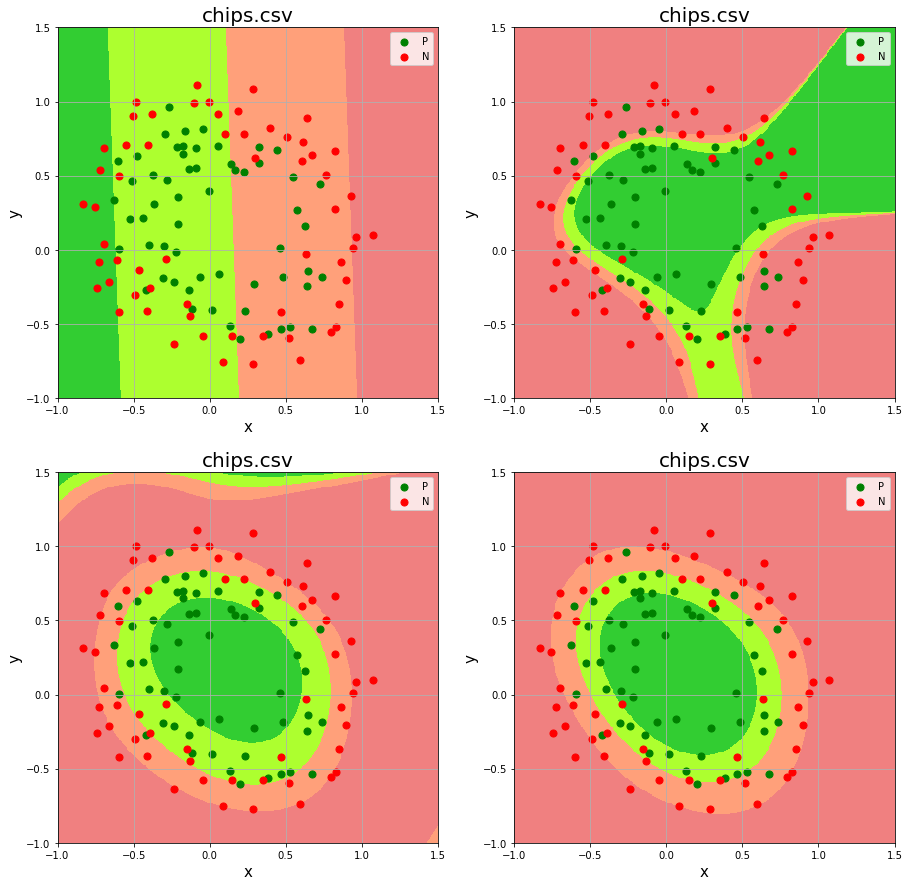

In [297]:
render_all("chips.csv", -1, 1.5, -1, 1.5, 
            chips_linear_kernel, chips_poly_kernel, chips_sigm_kernel, chips_rbf_kernel)

Linear:
Train SVM...
Calc colors...
160000/160000   

Poly:
Train SVM...
Calc colors...
160000/160000   

Rbf:
Train SVM...
Calc colors...
160000/160000   

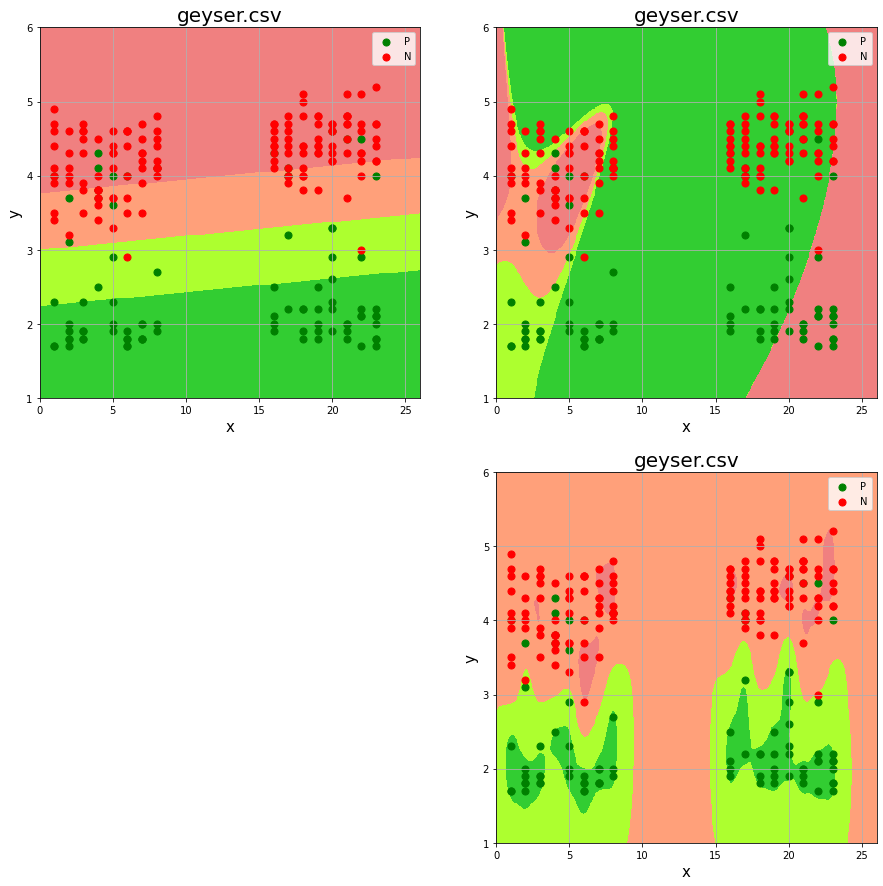

In [9]:
render_all("geyser.csv", 0, 26, 1, 6, 
            geyser_linear_kernel, geyser_poly_kernel, geyser_sigm_kernel, geyser_rbf_kernel)